In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme()

In [2]:
###################
### Parameters ###
###################

###############
## FOR MODEL ##
###############

data = {
'interest_rate' : 0.02,
'agents' : 200,
'periods' : 2000
}

################
## FOR AGENTS ##
################
data.update({
       
# Wealth distribution parameter: The higher, the higher the inequality
"inequality_wealth" : 2, 

# Skills distribution parameter: The higher, the higher the inequality
"inequality_skills" : 2,
"weight_gen_skills" : 0.5, # theta in the paper

# Qualities and varieties parameters
"qualities" : 10, # Q in the paper
"varieties" : 10, # J in the paper

# Own good pricing parameters
"a" : 1, # a in the paper
"alpha" : 1, # alpha in the paper

# Connectivity limits, parameters
"min_connectivity" : 2, # This is the N^0 of the paper
"max_connectivity" : data['agents'] - 1, # This is the \tilde{N} of the paper.

# Propensity to consume parameters
"pc_a" : 0.5, # a in the paper
"pc_c_l" : 0.1, # paper's c_l
"pc_c_h" : 0.9, # paper's c_h

# Connectivity update parameters
"connect_w" : 0.5, # w in the paper
"connect_b" : 0.5, # w in the paper

# Animal spirits parameters
"as_gamma" : 0.5, # gamma constant in the paper
"as_g" : 0.5, # g constant in the paper

# Moral behavior parameters
"mb_z" : 0.5, # constant z in the paper
"mb_zeta" : 0.5, # constant greek zeta in the paper

# Political view parameters
"pv_x" : 0.5, # constant x in the paper
"pv_omega" : 0.5 # constant omega in the paper
})

In [3]:
from model import model

mymodel = model(data)

for _ in range(data['periods']):
    mymodel.step()

#############################
#   Get and store the data  #
#############################

results_model = mymodel.datacollector.get_model_vars_dataframe()
results_model.to_csv('results_model.csv')

results_agents = mymodel.datacollector.get_agent_vars_dataframe()
results_agents.to_csv('results_agents.csv')

g:\My Drive\Work\Research\Economics\Ongoing\ABM Wealth\ABM-Project-ISCAL\virtenv\Lib\site-packages\mesa\time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


KeyError: 'self.qualities'

In [ ]:
df_model = pd.read_csv('results_model.csv', index_col = 0)
df_agents = pd.read_csv('results_agents.csv', index_col = [0, 1])

In [ ]:
number_of_agents = df_agents.loc[(1, slice(None)), :].shape[0]
number_of_periods = df_agents.loc[(slice(None), 1), :].shape[0]
print(f'We have a total of {number_of_agents} agents in the simulation, that ran for {number_of_periods-1} periods.')

n_rand_agents = 3
random_agents = random.sample(range(0, number_of_agents), n_rand_agents)

sample_agents = []

for i in random_agents:
    sample_agents.append(df_agents.loc[(slice(None) , i) , :].reset_index(level = 1, drop = True))

We have a total of 200 agents in the simulation, that ran for 2000 periods.


## Some random agents

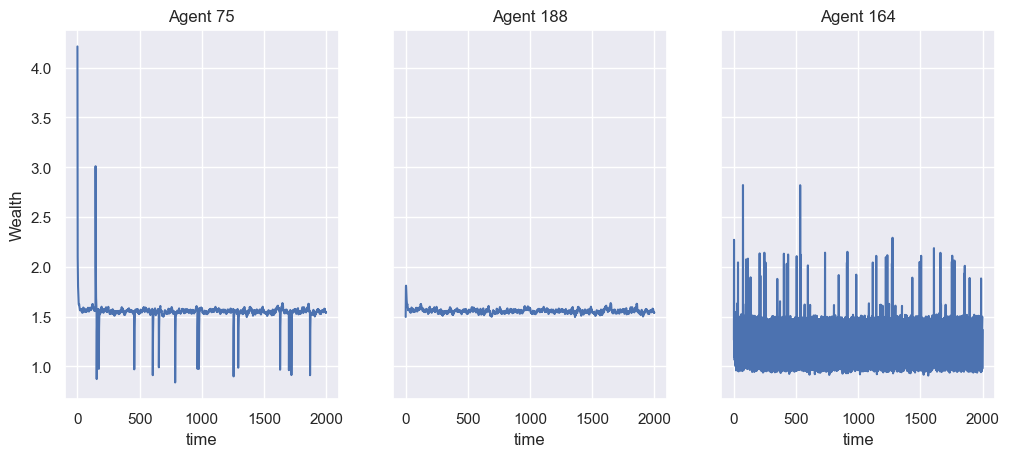

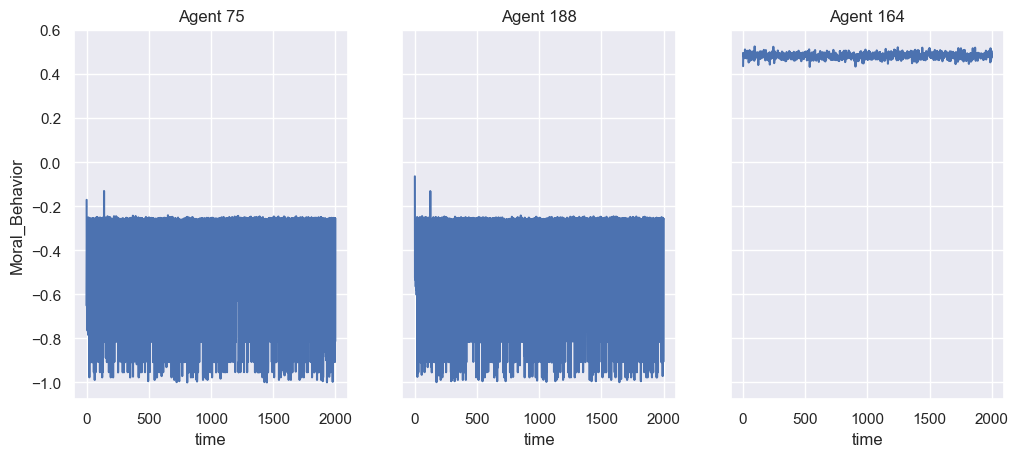

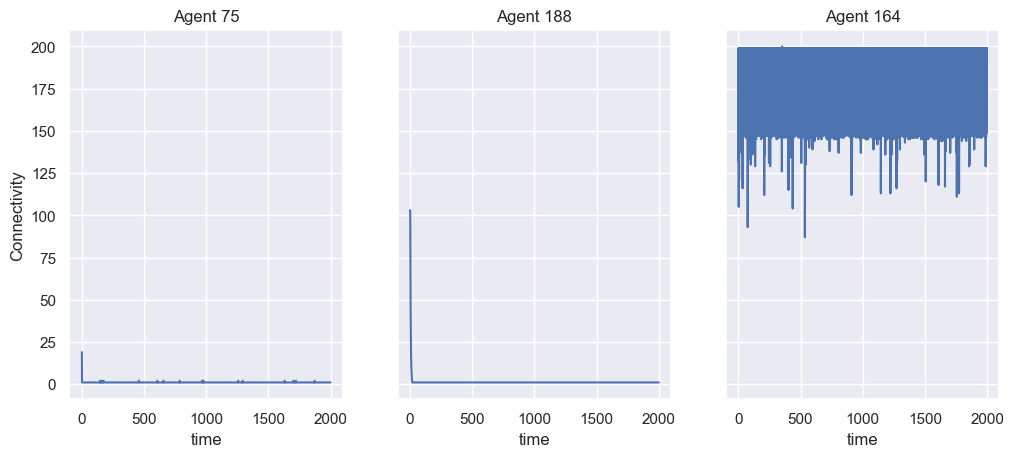

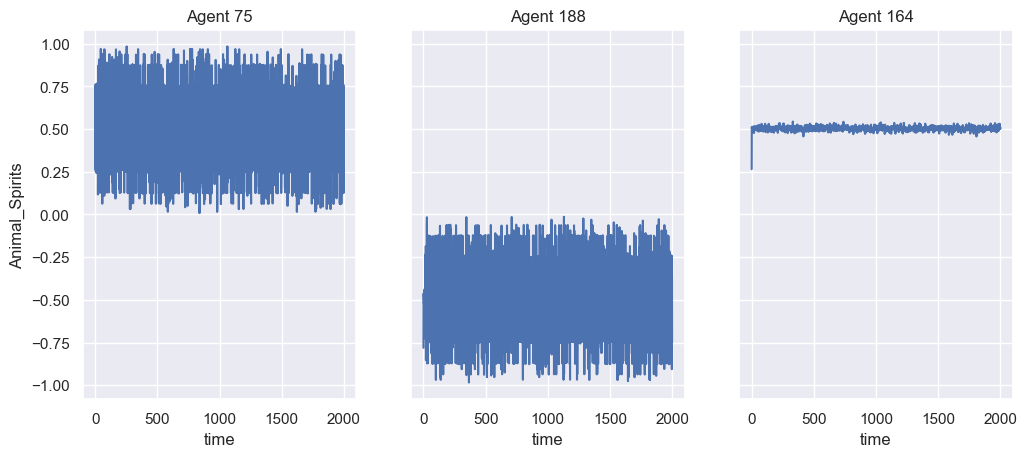

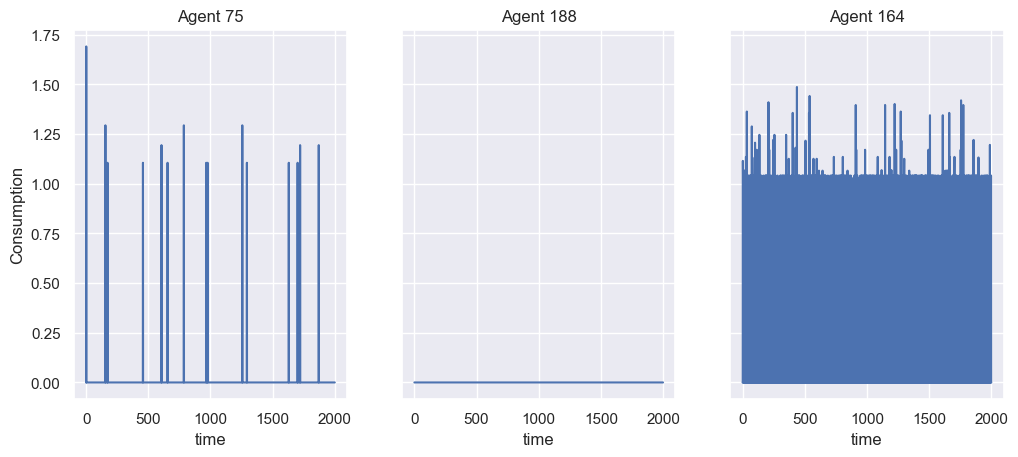

In [ ]:
vars_to_plot = ['wealth', 'moral_behavior', 'connectivity', 'animal_spirits', 'consumption']

for v in vars_to_plot:

    fig, ax = plt.subplots(nrows=1, ncols=len(random_agents), sharey = True);
    fig.set(figwidth = 12)

    #ax[0].set_ylabel('Wealth');
    ax[0].set_ylabel(str.title(v));

    for i in range(n_rand_agents):
        ax[i].plot(sample_agents[i][v]);
        ax[i].set_xlabel('time');
        ax[i].set_title(f'Agent {random_agents[i]}');

## Distributions

In [ ]:
def create_partitions(arr, n):
  size = len(arr)

  if n >= size:
    return list(range(size))
  elif size == 1:
    return [0]
  else:
    return [int(np.floor(i*(size-1)/(n-1))) for i in range(n)]

def make_hist(col):
  global steps
  subsample_cross = create_partitions(range(df_model.shape[0]), 6)

  plt.figure(figsize=(15, 15 ))
  plt.subplots_adjust(hspace=0.2)
  #plt.suptitle(f"{col} at t={[i for i in subsample_cross]}", fontsize=16, y=0.95)
  plt.suptitle(f"{str.title(col)}", fontsize=16, y=0.95)

  ncols = 3
  nrows = 3

  axes = []

  for n, ticker in enumerate(subsample_cross):
      if n == 0:
        axes.append(plt.subplot(nrows, ncols, n + 1))
      else:
        axes.append(plt.subplot(nrows, ncols, n + 1, sharey = axes[0]))
      axes[n].set_title(f't = {subsample_cross[n]}')
        
      df_agents.loc[(ticker, slice(None)), col].hist(ax = axes[n], bins = 20, weights = np.zeros_like(df_agents.loc[(ticker, slice(None)), col]) + 1./df_agents.loc[(ticker, slice(None)), col].size)

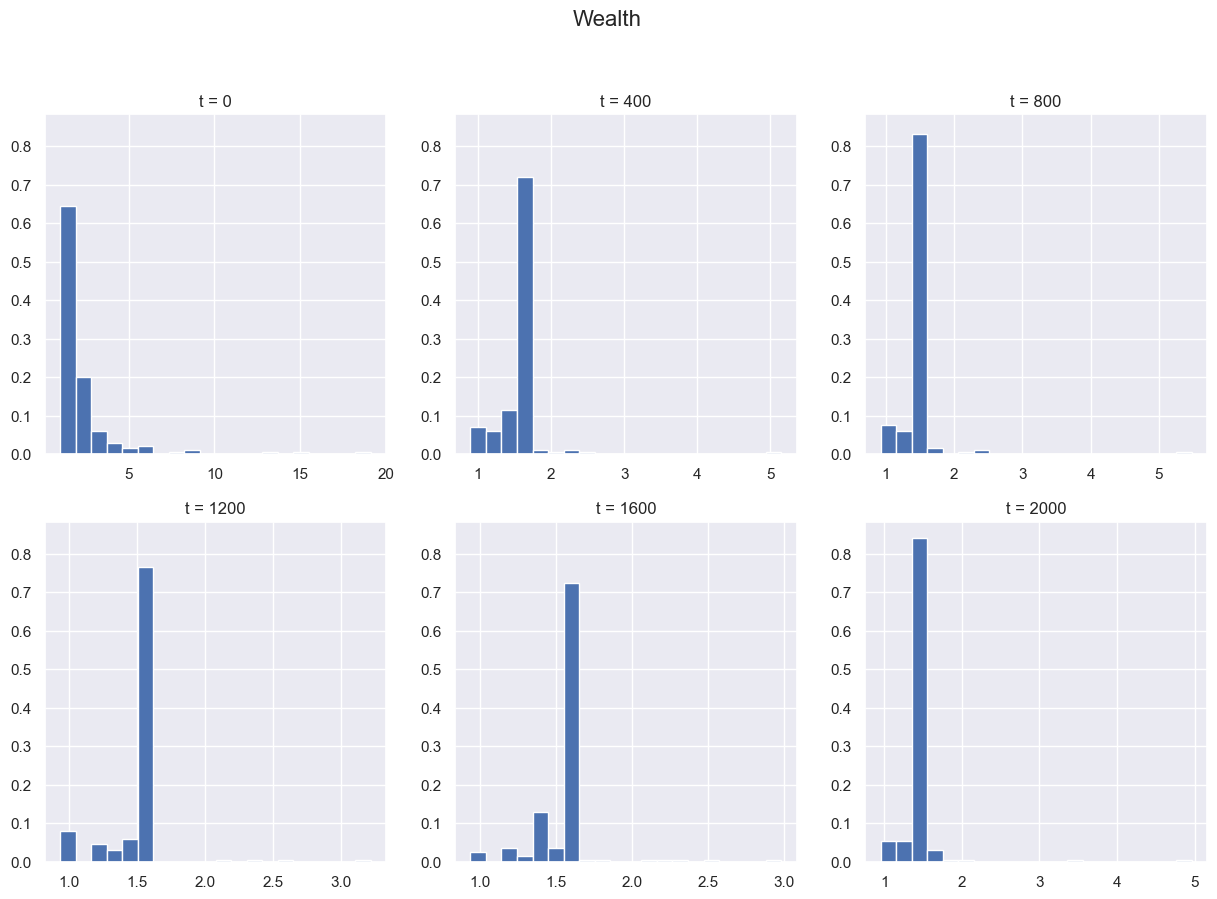

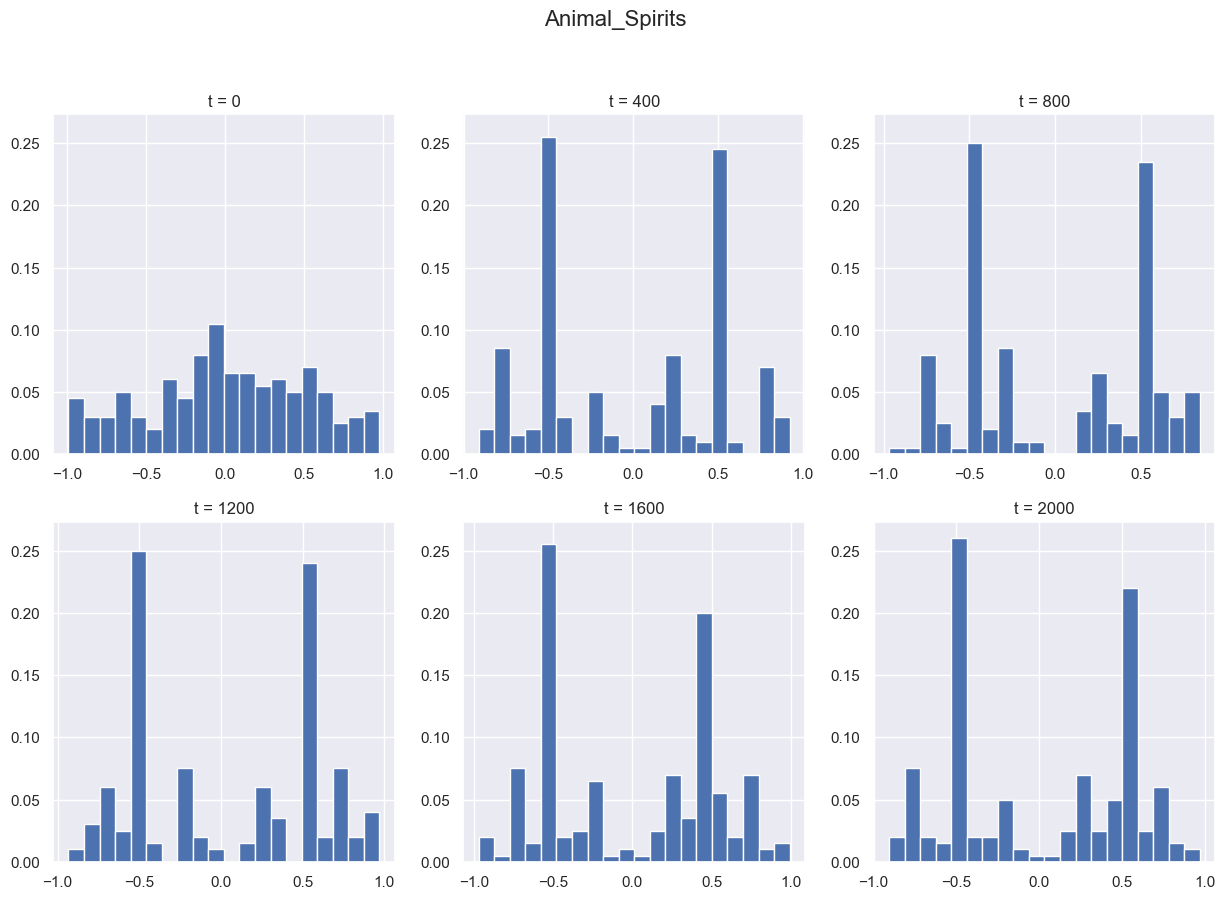

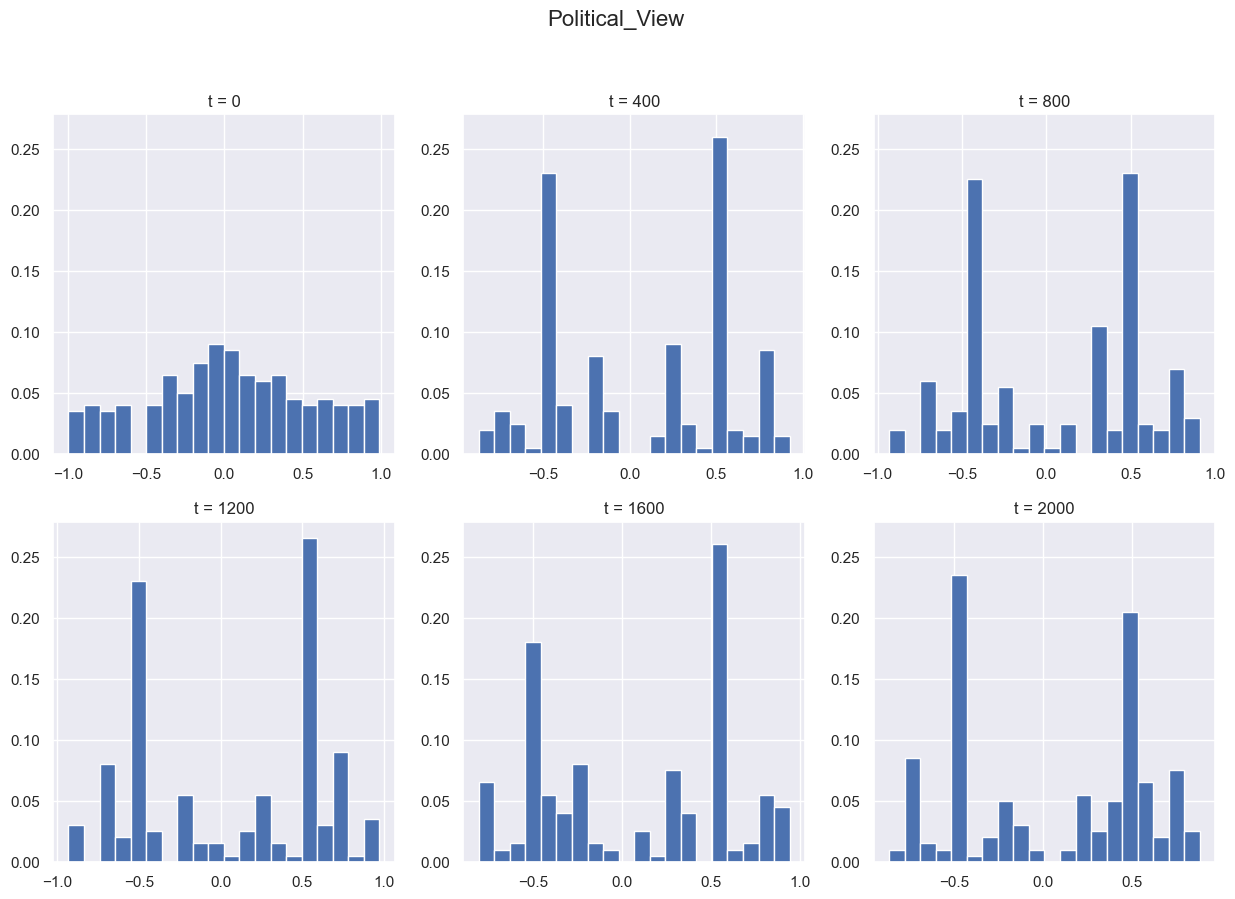

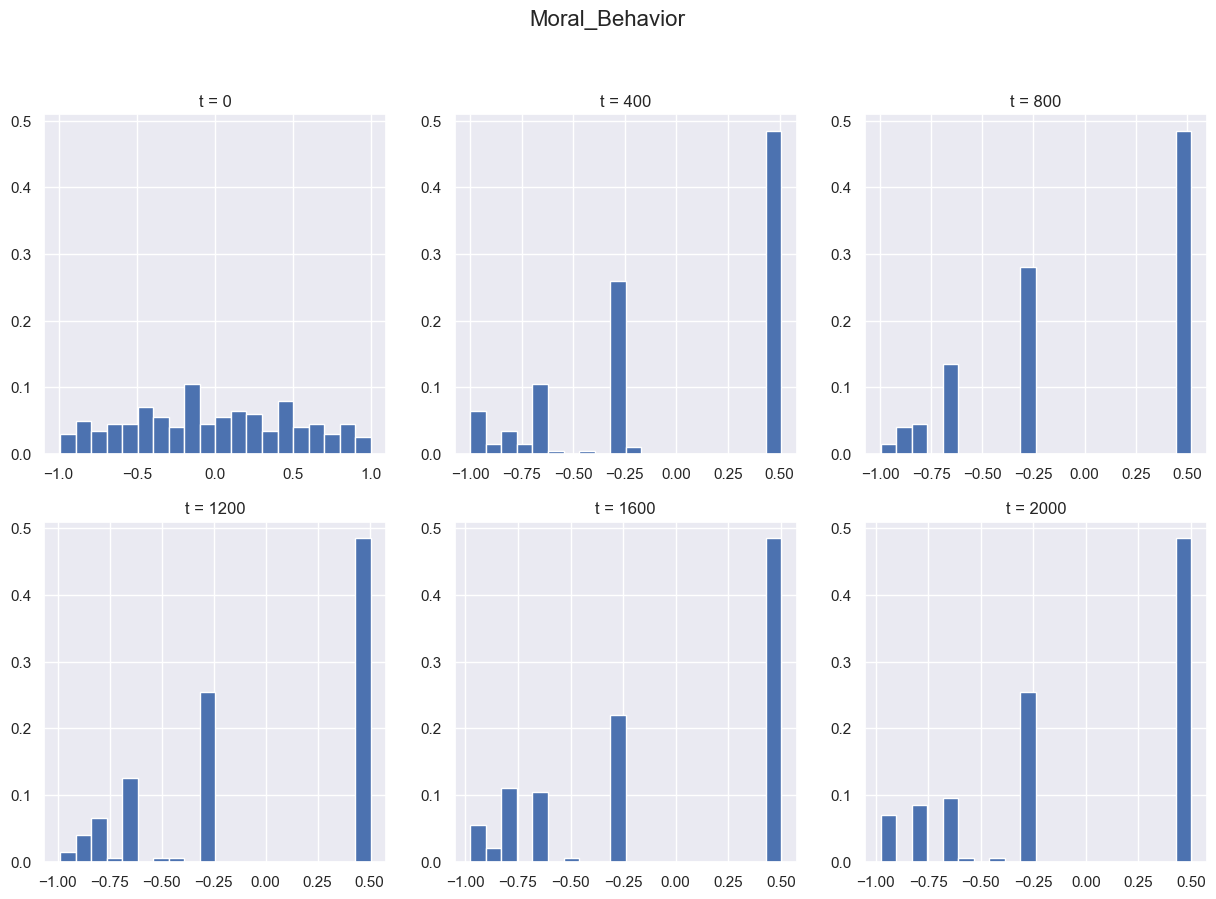

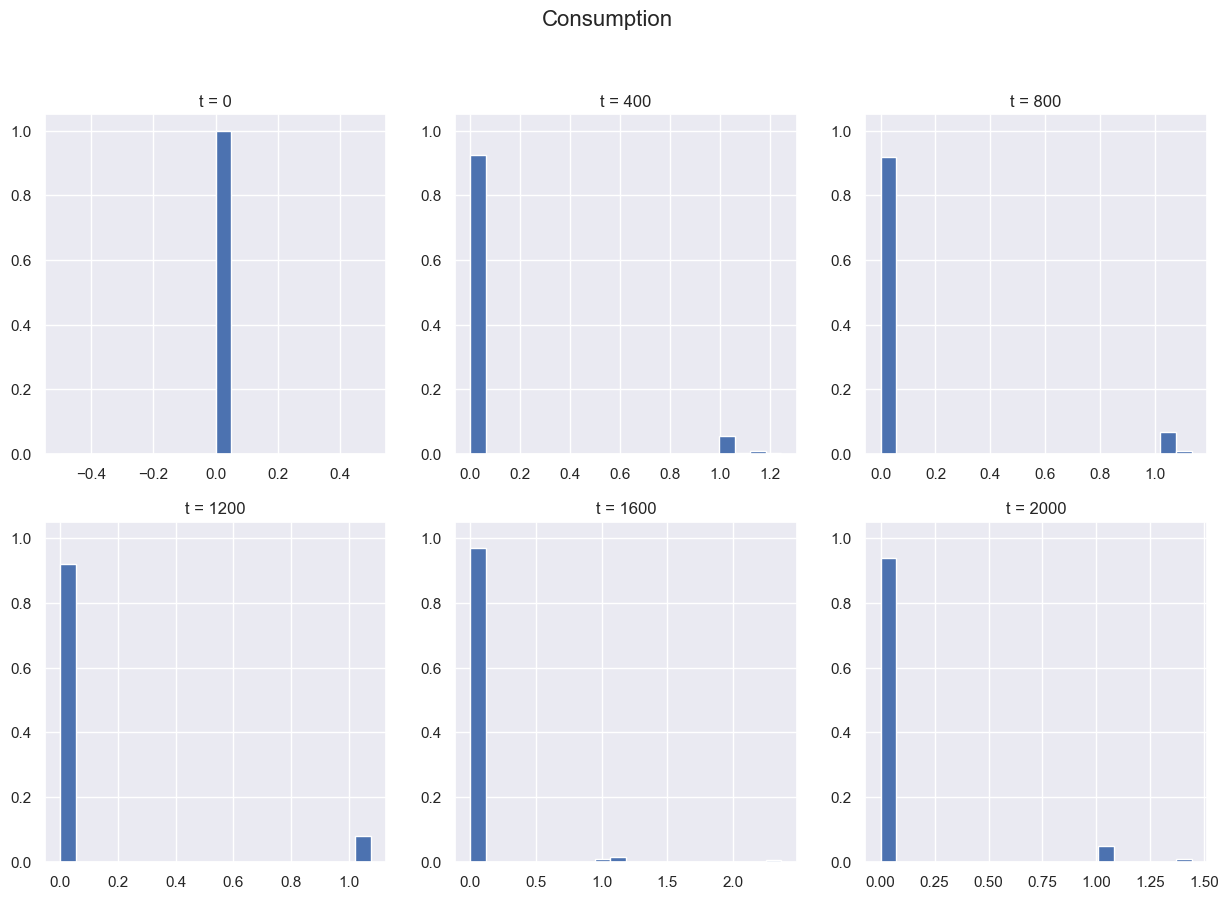

In [ ]:
cols = ['wealth', 'animal_spirits', 'political_view', 'moral_behavior', 'consumption']
for c in cols:
  make_hist(c)

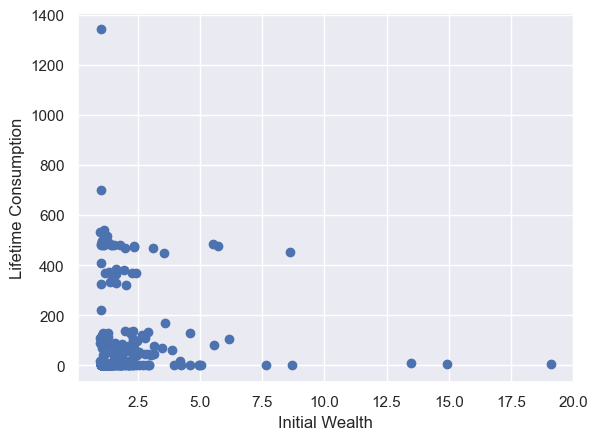

In [ ]:
agents_lifetime_consumption = df_agents['consumption'].unstack().sum()
agents_initial_wealth = df_agents['wealth'].unstack().iloc[0,:]

plt.scatter(y = agents_lifetime_consumption, x = agents_initial_wealth);
plt.xlabel('Initial Wealth');
plt.ylabel('Lifetime Consumption');

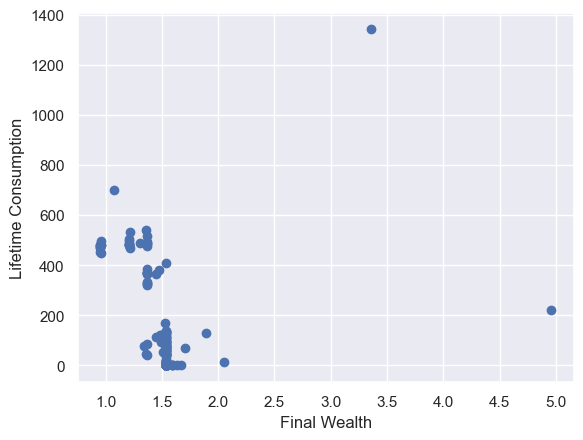

In [ ]:
agents_final_wealth = df_agents['wealth'].unstack().iloc[df_model.shape[0] - 1,:]

plt.scatter(y = agents_lifetime_consumption, x = agents_final_wealth);
plt.xlabel('Final Wealth');
plt.ylabel('Lifetime Consumption');

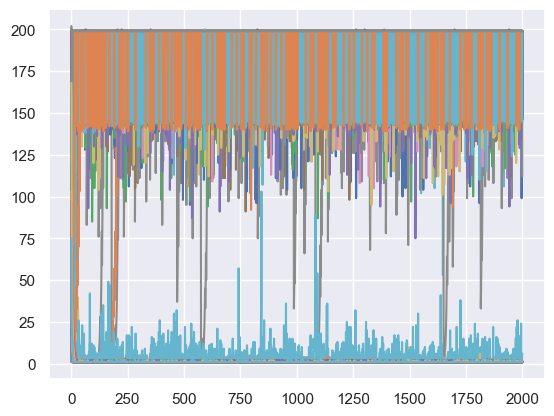

In [ ]:
plt.plot(df_agents['connectivity'].unstack());

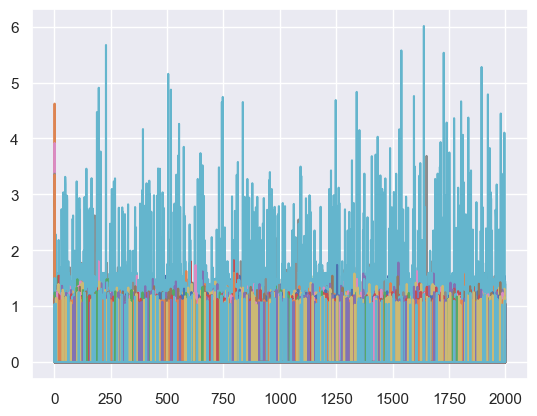

In [ ]:
plt.plot(df_agents['consumption'].unstack());

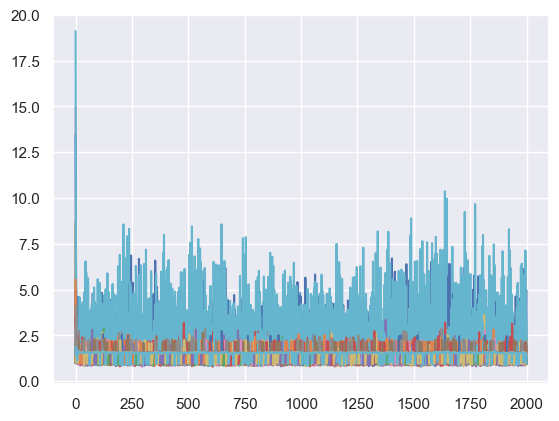

In [ ]:
plt.plot(df_agents['wealth'].unstack());

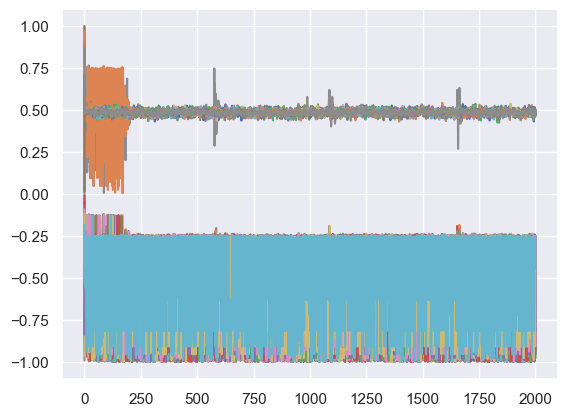

In [ ]:
plt.plot(df_agents['moral_behavior'].unstack());

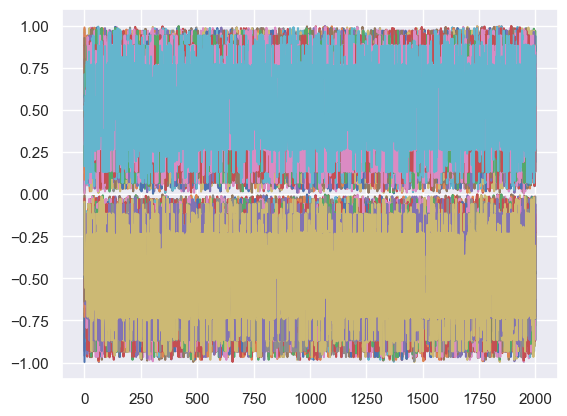

In [ ]:
plt.plot(df_agents['political_view'].unstack());